# SD201: Classification

The goal of this lab is to make you familiar with classification algorithms and their uses for large dataset mining. We will focus on a relatively small dataset of various measurements of penguins.

## Imports

In [1]:
!pip install xgboost

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score,confusion_matrix, classification_report

import xgboost as xgb
import seaborn as sns

## Data and split

We will focus on two datasets: the _Palmer penguins_ dataset is a small dataset about penguins, where the target classes (species or location) are well separated.

In [3]:
penguins = pd.read_csv(open("data/penguins_lter.csv"))

In [4]:
penguins

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,PAL0910,120,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A2,No,12/1/09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,PAL0910,121,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N39A1,Yes,11/22/09,46.8,14.3,215.0,4850.0,FEMALE,8.41151,-26.13832,NaN
341,PAL0910,122,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N39A2,Yes,11/22/09,50.4,15.7,222.0,5750.0,MALE,8.30166,-26.04117,NaN
342,PAL0910,123,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N43A1,Yes,11/22/09,45.2,14.8,212.0,5200.0,FEMALE,8.24246,-26.11969,NaN


### Data exploration

Start by exploring the data. How is each feature distributed? What is the balance between the classes? Which features are correlated with each other?

### Data cleaning

First of all, we need to clean up the data. This involves dealing with the NaN values, deciding if we want to center (and reduce) features.

### Train and test datasets

Write a short function that splits your data into train and test dataset. The skeleton is given below. For pedagogical purposes, you cannot use the existing `scikit-learn` function.

In [5]:
def train_test_split(data, target_col, percent_split=0.85):
    data = data.sample(frac=1)
    X_train, y_train, X_test, y_test = ([], [], [], [])
    int_treshold = int(len(data) * 0.85)
    
    y = data[target_col]
    data.drop(target_col, axis=1, inplace=True)
    
    y_train = y[:int_treshold]
    y_test = y[int_treshold:]
    
    X_train = data[:int_treshold]
    X_test = data[int_treshold:]
    
    return X_train, y_train, X_test, y_test

### Numerical-only version of the data

Some of the algorithms we studied only work with numerical features. Make an alternate version of our dataset, where non-numerical features are transformed. You can use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) for categorical variables. To make first tests, you can simply drop the non-numerical features.

In [6]:
penguins_num = pd.DataFrame()
penguins_num = penguins.drop(["Stage", "Sample Number", "Date Egg", "Region", "Island", "studyName", "Individual ID", "Clutch Completion", "Sex", "Comments"], axis=1)
penguins_num.fillna(0.0, inplace=True)

In [7]:
target = penguins_num["Species"]
targ_cat = target.replace('Adelie Penguin (Pygoscelis adeliae)', 0)
targ_cat = targ_cat.replace('Chinstrap penguin (Pygoscelis antarctica)', 1)
targ_cat = targ_cat.replace('Gentoo penguin (Pygoscelis papua)', 2)
penguins_num["Species"] = targ_cat

In [8]:
X_train, y_train, X_test, y_test = train_test_split(penguins_num, "Species")

## Classification



Now that the data is ready, let us focus on the classification task itself. Our goal will be to predict the penguins' species (it is an example, you can use another column if you prefer). As a quick exercise, let us suppose that we create a very naive baseline, that always predict the same species for every penguin in the test set. In terms of evaluation, supposing our test set is distributed similarly to our train set, what will be the F1-score for this baseline?

Calculate it, then implement this baseline to verify your prediction.

## $k$-nearest neighbours

Let us start with the $k$-nearest neighbours algorithm, to ensure that we have a simple yet realistic baseline. Write the code for the $k$-nearest neighbors algorithm. You can implement the $n$-dimensional Euclidean distance to find the nearest neighbors. Given an instance of the data, your code should predict its target class.

In [9]:
def knn(x, data, target_col="Species", n_neighbors=5):
    """
        x: an instance of the data (can be passed as the row number of the instance in data)
        data: the full data
        target_col: the feature/column that should be predicted
        n_neighbors: the number of neighbors to use when making the majority vote
        
        return x, predicted_class: the instance (or its row number), and the predicted class for this instance 
    """
    
    return x, predicted_class


#### If you are stuck...

You can use the algorithm as implemented in `scikit-learn`. Notice that there is a `fit()` and `predict()` function. This is partly to keep the ususal sklearn API, but also to index the data preventively, in order to make the prediction faster.

In [10]:
knn = KNeighborsClassifier()
knn.fit(X_train, np.array(y_train))
y_pred = knn.predict(X_test)

Evaluate the classification results using the metric we saw in class: the accuracy ($\frac{\#correct\_predictions}{\#total\_predictions}$) and the [F1-score](https://en.wikipedia.org/wiki/F-score).

In [11]:
f1_score(y_pred, y_test, average="micro")

0.7692307692307693

The `KNeighborsClassifier` can take the argument `num_neighbors`, setting the $k$ for $k$-nearest neighbors. This parameter defaults to $5$. Plot the F1-score against the `n_neighbors` value. What can you conclude on the choice of $k$?

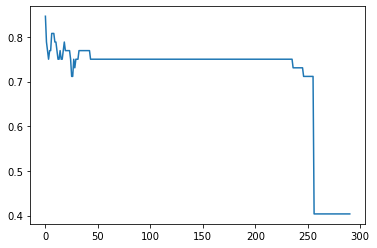

In [12]:
y_vals = []
for i in range(1, 292):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, np.array(y_train))
    y_pred = knn.predict(X_test)
    y_vals.append(f1_score(y_pred, y_test, average="micro"))
plt.plot(y_vals);

The $k$-NN algorithm can be made better if each point does not contribute the same amount of information. This scenario is called **weighted $k$-NN**. Adapt your algorithm to consider a weighing scheme. You can devise your own, or use the rule that each neighbor counts proportionally to its position in the list (the nearest neighbor contributes more than the second-nearest neighbor, who contributes more than the third nearest neighbor, etc.)

## Decision trees

Let us use better models, based on decision trees. We will use first one single decision tree, then compare this to a random forest model, and finally to a gradient boosting machine.

### Single decision tree

In [13]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [14]:
f1_score(y_test, y_pred, average="micro")

0.9615384615384616

Compute and plot the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

Using the `plot_tree` function, plot the decision tree that was built.

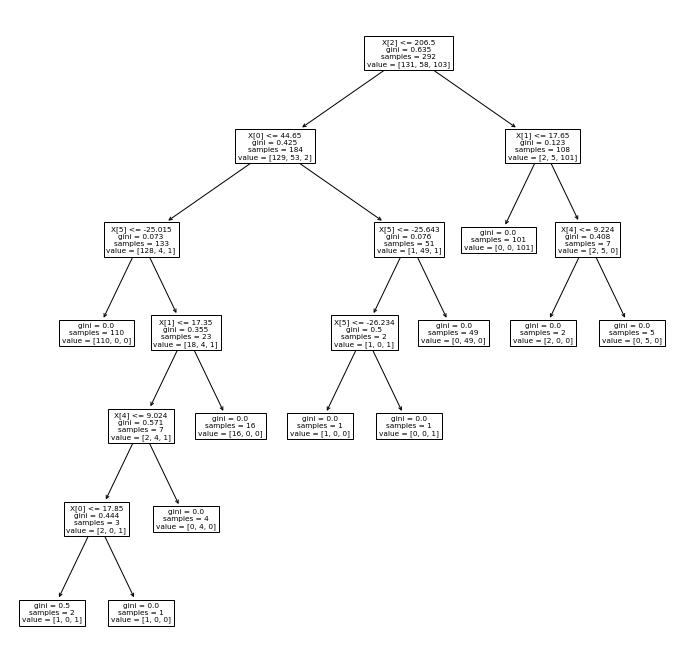

In [15]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12,12))
plot_tree(dt);

### Random Forest

In [83]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [84]:
f1_score(y_test, y_pred, average="micro")

1.0

Compute and plot the confusion matrix.

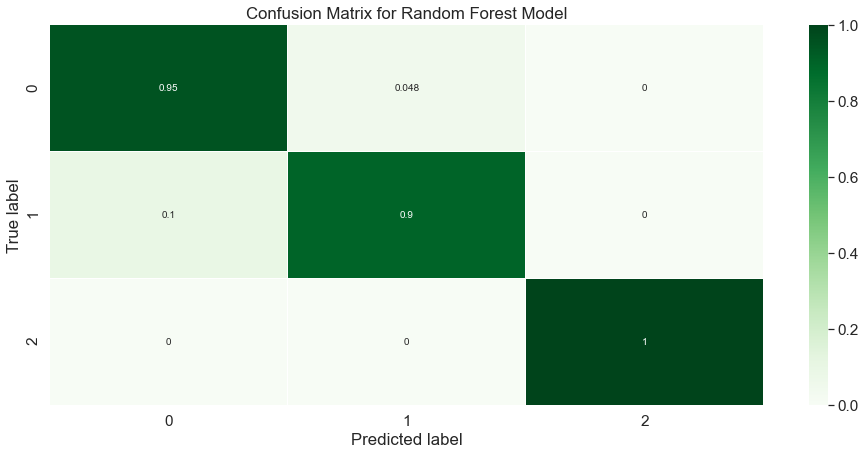

In [28]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
#class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
#               'Cottonwood/Willow', 'Aspen', 'Douglas-fir',    
#               'Krummholz']
#tick_marks = np.arange(len(class_names))
#tick_marks2 = tick_marks + 0.5
#plt.xticks(tick_marks,  rotation=25)
#plt.yticks(tick_marks2, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

### Gradient boosting machines

Let us move to gradient boosting machines. We will use the `xgboost` library.

In [85]:
xg = xgb.XGBClassifier(n_estimators=100)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

[20:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tipha\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


What is the classification error using gradient boosted trees?

In [86]:
f1_score(y_test, y_pred, average="micro")

1.0

Here is a dictionary with the main parameters of the `xgboost` model. What is the impact of each parameter on the global F1-score? On the quality of the predictions?

In [87]:
params = {
    "n_estimators": 10, #number of trees (i.e. iterations)
    "max_depth": 8, # Maximum depth of built trees
    "min_child_weight" : 0, # Minimum sum of instance weight(hessian) needed in a child.
    "subsample": 1.0, # Subsample ratio of the training instance.
    "colsample_bytree" : 1.0 # Subsample ratio of columns when constructing each tree.
}

xg = xgb.XGBClassifier(params)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
f1_score(y_test, y_pred, average="micro")

[20:44:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tipha\anaconda3\lib\site-packages\xgboost\core.py:499: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\tipha\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1.0

Compute and plot the confusion matrix.

### Focus: feature importance charts with decision trees

One neat thing about decision trees is that we can use the number of times a feature was used to make a _split_ in the decision tree as a proxy for feature importance. For one of your decision tree models, plot the feature importance (scikit-learn stores it as the `feature_importances_` attribute).

In the three tree-based models we used, what is the importance of each feature? Make the plots and comment.

## Bonus: a more complex dataset

Let us now use the code and insights we gained on a clear dataset to a more realistic dataset. The following code downloads in a Pandas dataframe information about red and white wines, with some features. Your goal is to explore, analyze and run classification algorithms on the data to determine if a wine is _poor_, _normal_ or _excellent_. Notice that as an additional challenge, the classes are not balanced here: there are many more _normal_ wines than _poor/excellent_ wines. 

In [100]:
import urllib
import zipfile
import io

Url = "http://tiphaineviard.com/files/winequality.zip"
with urllib.request.urlopen(Url) as Response:
    Length = Response.getheader('content-length')
    BlockSize = 1000000  # default value

    if Length:
        Length = int(Length)
        BlockSize = max(4096, Length // 20)

    print("UrlLib len, blocksize: ", Length, BlockSize)

    BufferAll = io.BytesIO()
    Size = 0
    while True:
        BufferNow = Response.read(BlockSize)
        if not BufferNow:
            break
        BufferAll.write(BufferNow)
        Size += len(BufferNow)
        if Length:
            Percent = int((Size / Length)*100)
            print(f"download: {Percent}% {Url}")

    print("Buffer All len:", len(BufferAll.getvalue()))
with open("data/winequality.zip", "wb") as fp:
    fp.write(BufferAll.getbuffer())
    
with zipfile.ZipFile("data/winequality.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")    


UrlLib len, blocksize:  100892 5044
download: 4% http://tiphaineviard.com/files/winequality.zip
download: 9% http://tiphaineviard.com/files/winequality.zip
download: 14% http://tiphaineviard.com/files/winequality.zip
download: 19% http://tiphaineviard.com/files/winequality.zip
download: 24% http://tiphaineviard.com/files/winequality.zip
download: 29% http://tiphaineviard.com/files/winequality.zip
download: 34% http://tiphaineviard.com/files/winequality.zip
download: 39% http://tiphaineviard.com/files/winequality.zip
download: 44% http://tiphaineviard.com/files/winequality.zip
download: 49% http://tiphaineviard.com/files/winequality.zip
download: 54% http://tiphaineviard.com/files/winequality.zip
download: 59% http://tiphaineviard.com/files/winequality.zip
download: 64% http://tiphaineviard.com/files/winequality.zip
download: 69% http://tiphaineviard.com/files/winequality.zip
download: 74% http://tiphaineviard.com/files/winequality.zip
download: 79% http://tiphaineviard.com/files/winequ

In [107]:
data_red = pd.read_csv("data/winequality-red.csv")
data_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [109]:
data_white = pd.read_csv("data/winequality-white.csv", sep=";")
data_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
